# 画像生成 AI 入門: Python による拡散モデルの理論と実践
## Section 07. Play with Diffusion Model

Stable Diffusion を中心とした拡散モデルを用いて、最先端の画像生成技術を実際に動かして実践していきます。

### Lecture 21. DreamBooth

DreamBooth [[Ruiz+ CVPR'23]](https://arxiv.org/abs/2208.12242) を用いて Stable Diffusion に新しい概念（コンセプト; concept）を「教える」方法を紹介します。

## セットアップ

### GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度講義資料の `GPU 使用設定` のスライド説明や Google Colab の [FAQ](https://research.google.com/colaboratory/faq.html#gpu-utilization) 等を参考にランタイムタイプが正しく変更されているか確認してください。

In [1]:
!nvidia-smi

Sun Jul 30 02:05:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 利用する Python ライブラリをインストール

diffusers ライブラリをインストールすることで拡散モデルを簡単に使用できるようにします。diffusers ライブラリを動かす上で必要となるライブラリも追加でインストールします:
- [transformers](https://github.com/huggingface/transformers): 拡散モデルにおいて核となる Transformer モデルが定義されているライブラリ
- [accelerate](https://github.com/huggingface/accelerate): transformers と連携してより高速な画像生成をサポートするライブラリ
- [xformers](https://github.com/facebookresearch/xformers): accelerate と同様に、Transformer モデルをより効率的に扱い高速な画像生成をサポートするライブラリ
- [bitsandbytes](https://github.com/TimDettmers/bitsandbytes): 通常単精度 float32 であるところを半精度 float16 よりも少ない 8-bit でのモデルの読み込みが可能なライブラリ

In [2]:
!pip install diffusers==0.16.1
!pip install transformers accelerate xformers bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.6 MB/s eta 0:00:00


## DreamBooth

本セクションでは [Dreambooth fine-tuning for Stable Diffusion using d🧨ffusers](https://github.com/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_training.ipynb) を参考に、dreambooth の動作を追っていきます。

前回の講義で取り扱った Textual Inversion とは異なり、本手法はモデル全体を学習させるため学習に利用できるパラメータ数が増えることになり結果的によりよい画像を生成することが可能です。一方で学習するパラメータが増えることで学習時間も長くなります。

まず準備として画像を複数生成した場合に結果を確認しやすいように、画像をグリッド上に表示する関数を以下のように定義します。この関数は [🤗 Hugging Face Stable Diffusion](https://huggingface.co/blog/stable_diffusion) のブログ記事のものを利用しています。

In [3]:
from typing import List
from PIL import Image
from PIL.Image import Image as PilImage

def image_grid(imgs: List[PilImage], rows: int, cols: int) -> PilImage:
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

### 新たな概念をモデルに教えるための設定

使用する事前学習済み拡散モデルを指定します。今回は [`runwayml/stable-diffusion-v1-5`](https://huggingface.co/runwayml/stable-diffusion-v1-5) を選択しました。

In [4]:
model_id = "runwayml/stable-diffusion-v1-5"

Google drive にデータを保存する設定を行います。`Files` タブから google drive に用意した画像を読み込むことも可能ですが、今回は google drive をマウントし、そこから drive 上に保存した画像を読み込む方法を検討します。

In [5]:
import os
from google.colab import drive

# /content/drive をマウントする
DRIVE_PATH = os.path.join(os.sep, "content", "drive")
print(f"Mount the following directory: {DRIVE_PATH}")

drive.mount(DRIVE_PATH)

#
# 本 notebook 用のデータを格納するディレクトリを作成する
# まずベースとなるディレクトリとして以下のようなディレクリを作成する:
# /content/drive/MyDrive/colab-notebooks/oloso/practice
#
base_dir_path = os.path.join(DRIVE_PATH, "MyDrive", "colab-notebooks", "coloso", "practice")
#
# 次に講義用のディレクトリを作成する。今回は第 20 講なので `lecture-21` と命名する:
# /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-21
#
lecture_dir_path = os.path.join(base_dir_path, "lecture-21")

#
# 今回使用する学習画像を保存するディレクトリを作成する:
# /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-21/sample-images
#
sample_image_dir_path = os.path.join(lecture_dir_path, "sample-images")
print(f"The images will be saved in the following path: {sample_image_dir_path}")

# 上記のディレクトリが存在しない場合は作成する
if not os.path.exists(sample_image_dir_path):
    os.makedirs(sample_image_dir_path)

Mount the following directory: /content/drive
Mounted at /content/drive
The images will be saved in the following path: /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-21/sample-images


学習に使用するデータを用意します。今回は textual inversion にも登場している猫のおもちゃを [huggingface dataset](https://huggingface.co/datasets/diffusers/cat_toy_example) 上からダウンロードしてきます。ここではまず Colab 上でダウンロードしたのちに、google drive に保存する方法を取ります。以下の `urls` に学習したい概念の画像の URL を追加してください。dreambooth は数枚の画像で学習が可能であるため、3 〜 5 枚で十分です。

In [6]:
urls = [
    "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/1.jpeg",
    "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/2.jpeg",
    "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/3.jpeg",
    "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/4.jpeg",
    #
    # ここに更に画像を追加することができます
    #
    # "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/5.jpeg",
    # "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/6.jpeg",
    # "https://huggingface.co/datasets/diffusers/cat_toy_example/resolve/main/7.jpeg",
]

オンラインにある画像をダウンロードする関数を以下のように定義します。この関数を使って上記の `urls` で指定した画像をインターネット上からダウンロードします。

In [7]:
import requests

def download_image(url: str) -> PilImage:
    return Image.open(requests.get(url, stream=True).raw)

for i, url in enumerate(urls):
    image = download_image(url)
    image_filepath = os.path.join(sample_image_dir_path, f"{i}.jpg")
    print(f"The image is saved in the following path: {image_filepath}")
    image.save(image_filepath)

The image is saved in the following path: /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-21/sample-images/0.jpg
The image is saved in the following path: /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-21/sample-images/1.jpg
The image is saved in the following path: /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-21/sample-images/2.jpg
The image is saved in the following path: /content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-21/sample-images/3.jpg


準備した画像を確認してみます。

In [8]:
images: List[PilImage] = []
for file_path in os.listdir(sample_image_dir_path):
    image_filepath = os.path.join(sample_image_dir_path, file_path)
    image = Image.open(image_filepath)
    image = image.resize((512, 512))
    images.append(image)

image_grid(images, rows=1, cols=len(images))

Output hidden; open in https://colab.research.google.com to view.

学習したい概念に対する dreambooth の設定を行います。特に dreambooth では事前学習によって得られている事前知識を保存するかを指定するパラメータが存在します。
- `instance_prompt` には学習させたい概念を適切に説明し、なおかつ初期化トークン (initializer token) である `<cat-toy>` が含まれている必要があります。
- `is_prior_preservation` には概念のクラス（例: おもちゃ、犬、絵画等）が保存されることを保証したい場合に使用します。学習時間が少し伸びますが、生成品質が向上します。
- `prior_preservation_class_prompt` には概念のクラスを保存するために利用するプロンプトを指定します。

In [16]:
instance_prompt = "<cat-toy> toy"

is_prior_preservation = False
prior_preservation_class_prompt = "a photo of a cat clay toy"

以下では事前知識の保存に関するハイパーパラメータを指定します。
- `num_class_images` には知識保存するクラスの画像を指定します。
- `prior_loss_weight` には知識保存するクラスに対する損失の重みを指定します。
- `prior_preservation_class_folder` には知識保存する画像の格納先を指定します。

In [9]:
num_class_images = 12
prior_loss_weight = 0.5
prior_preservation_class_dir = os.path.join(lecture_dir_path, "class-images")
# class_data_root = prior_preservation_class_dir
# class_prompt = prior_preservation_class_prompt

In [11]:
import torch

from typing import Optional, TypedDict
from torch.utils.data import Dataset
from torchvision import transforms
from transformers.tokenization_utils import PreTrainedTokenizer

#
# 加工したデータセットを辞書型のデータに加工する際に
# key の定義と対応する value の型アノテーションを宣言
#
# 以下のように宣言することで、想定とは異なるデータが
# 入ってきた場合にエラーを出すことができる
#
class ExampleRequired(TypedDict):
    instance_images: torch.Tensor
    instance_prompt_ids: torch.Tensor


class Example(ExampleRequired, total=False):
    class_images: torch.Tensor
    class_prompt_ids: torch.Tensor


class DreamBoothDataset(Dataset):
    def __init__(
        self,
        instance_data_root: str,
        instance_prompt: str,
        tokenizer: PreTrainedTokenizer,
        class_data_root: Optional[str] = None,
        class_prompt: Optional[str] = None,
        image_size: int = 512,
        is_center_crop: bool = False,
    ) -> None:
        self.image_size = image_size
        self.is_center_crop = is_center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = instance_data_root
        if not os.path.exists(self.instance_data_root):
            raise ValueError(
                f"The following `instance_data_root` does not exists: "
                f"{self.instance_data_root}"
            )

        self.instance_image_paths = [
            os.path.join(self.instance_data_root, file_path)
            for file_path in os.listdir(self.instance_data_root)
        ]
        self.num_instance_images = len(self.instance_image_paths)
        self.instance_prompt = instance_prompt
        self.dataset_length = self.num_instance_images

        #
        # class preservation まわりの設定
        #
        self.class_data_root = None
        if class_data_root is not None:
            self.class_data_root = class_data_root
            os.makedirs(self.class_data_root, exist_ok=True)

            self.class_image_paths = [
                os.path.join(self.class_data_root, file_path)
                for file_path in os.listdir(self.class_data_root)
            ]
            self.num_class_images = len(self.class_image_paths)
            self.data_length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt

        #
        # 前処理の設定
        #
        transform_list = [
            transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(image_size) if is_center_crop else transforms.RandomCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ]
        self.image_transforms = transforms.Compose(transform_list)

    def __len__(self) -> int:
        return self.dataset_length

    def load_image(self, image_path: str) -> torch.Tensor:
        image_pil = Image.open(image_path)
        if not image_pil.mode == "RGB":
            image_pil = image_pil.convert("RGB")

        # 前処理を実施
        return self.image_transforms(image_pil)

    def __getitem__(self, idx: int) -> Example:
        #
        # 画像の読み込み
        #
        instance_image_path = self.instance_image_paths[idx % self.num_instance_images]
        instance_image = self.load_image(instance_image_path)
        #
        # プロンプトのトークナイズ
        #
        instance_prompt_ids = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        # 入力するデータを辞書型に詰め込む
        example = {
            "instance_images": instance_image,
            "instance_prompt_ids": instance_prompt_ids
        }

        #
        # class preservation まわりの処理
        #
        if self.class_data_root:
            class_image = self.load_image(self.class_image_paths[idx % self.num_class_images])
            class_prompt_ids = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids

            example["class_images"] = class_image
            example["class_prompt_ids"] = class_prompt_ids

        return example

class preservation で使用する画像を生成します。これを使用することで、元々生成出来ていた画像を忘れずに、新たに入力する概念を学習することが可能です。

In [12]:
import gc
from diffusers import StableDiffusionPipeline
from tqdm.auto import tqdm

def generate_class_images() -> None:
    if not os.path.exists(prior_preservation_class_dir):
        os.makedirs(prior_preservation_class_dir)
    cur_class_images = len(os.listdir(prior_preservation_class_dir))

    if cur_class_images >= num_class_images:
        return

    pipe = StableDiffusionPipeline.from_pretrained(
        model_id, revision="fp16", torch_dtype=torch.float16
    )
    pipe = pipe.to("cuda")

    pipe.enable_attention_slicing()
    pipe.set_progress_bar_config(disable=True)

    num_new_images = num_class_images - cur_class_images
    print(f"Number of class images to sample: {num_new_images}")

    for idx in tqdm(range(0, num_new_images, 2), desc="Generating class images"):
        images = pipe(
            prompt=prior_preservation_class_prompt,
            num_images_per_prompt=2,
        ).images

        for i, image in enumerate(images):
            image_path = os.path.join(prior_preservation_class_dir, f"{cur_class_images + idx + i}.jpg")
            image.save(image_path)
            print(f"The generated image is saved in the following path: {image_path}")

    pipe = None
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

generate_class_images()

Stable Diffusion で学習されたコンポーネントをそれぞれ読み込みます。

In [13]:
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTokenizer, CLIPTextModel

text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")

学習データを、上記で定義した `DreamBoothDataset` を元に作成します。

In [17]:
train_dataset = DreamBoothDataset(
    instance_data_root=sample_image_dir_path,
    instance_prompt=instance_prompt,
    class_data_root=prior_preservation_class_dir if is_prior_preservation else None,
    class_prompt=prior_preservation_class_prompt,
    tokenizer=tokenizer,
    image_size=vae.config.sample_size,
    is_center_crop=True,
)


学習時に付与するノイズを制御するスケジューラを定義します。

In [18]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

学習の準備を行います。ハイパーパラメータを以下のように定義します。モデルを学習して生成結果を確認したときに結果が悪かった場合は、`learning_rate` や `max_train_steps` の調整を検討してみてください。

In [19]:
from dataclasses import dataclass

@dataclass
class Hyperparameter(object):
    learning_rate: float = 1e-6
    max_train_steps: int = 300
    train_text_encoder: bool = False
    train_batch_size: int = 1 # 事前知識の保存を行う場合はバッチサイズを 1 にしてください
    gradient_accumulation_steps: int = 1
    gradient_checkpointing: bool = True
    max_grad_norm: float = 1.0
    mixed_precision: str = "fp16"
    use_8bit_adam: bool = True # `bitsandbytes` による 8-bit 最適化を利用
    seed: int = 19950815
    lr_scheduler: str = "constant"
    lr_warmup_steps: int = 100
    output_dir_path: str = os.path.join(lecture_dir_path, "sd-dreambooth-output")

hparams = Hyperparameter()
print(hparams)

Hyperparameter(learning_rate=1e-06, max_train_steps=300, train_text_encoder=False, train_batch_size=1, gradient_accumulation_steps=1, gradient_checkpointing=True, max_grad_norm=1.0, mixed_precision='fp16', use_8bit_adam=True, seed=19950815, lr_scheduler='constant', lr_warmup_steps=100, output_dir_path='/content/drive/MyDrive/colab-notebooks/coloso/practice/lecture-21/sd-dreambooth-output')


In [21]:
import itertools
import math

import bitsandbytes as bnb

from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers.optimization import get_scheduler
import torch.nn.functional as F

logger = get_logger(__name__)

class BatchDict(TypedDict):
    input_ids: torch.Tensor
    pixel_values: torch.Tensor


def collate_fn(examples: List[Example]) -> BatchDict:
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]

    # concat class and instance examples for prior preservation
    if is_prior_preservation:
        input_ids += [example["class_prompt_ids"] for example in examples]
        pixel_values += [example["class_images"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids},
        padding="max_length",
        return_tensors="pt",
        max_length=tokenizer.model_max_length
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch


def training_function(text_encoder, vae, unet):

    # 学習の再現性を確保するために乱数の seed を固定
    set_seed(hparams.seed)

    accelerator = Accelerator(
        gradient_accumulation_steps=hparams.gradient_accumulation_steps,
        mixed_precision=hparams.mixed_precision,
    )

    # 2023/07 現在 `accelerate.accumulate` で 2 つのモデルを学習する際に
    # gradient accmuleration を使用することができません。これは `accelerate` でまもなく使用できるようになるようです
    # 対象の機能が導入されたら、将来的に以下のチェックを無効にすることを検討してください:
    if hparams.train_text_encoder and hparams.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
        raise ValueError(
            "Gradient accumulation is not supported when training the text encoder in distributed training. "
            "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
        )

    # VAE のパラメータを固定
    vae.requires_grad_(False)
    # Text Encoder のパラメータを固定するか判定
    if not hparams.train_text_encoder:
        text_encoder.requires_grad_(False)

    if hparams.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if hparams.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

    # Colab の T5 GPU のような、16 GB 以下の GPU RAM の場合は
    # fine-tuning 時のメモリ使用量を減らすために 8-bit の Adam optimizer を使用
    if hparams.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    params_to_optimize = (
        itertools.chain(unet.parameters(), text_encoder.parameters())
        if hparams.train_text_encoder
        else unet.parameters()
    )

    optimizer = optimizer_class(
        params_to_optimize,
        lr=hparams.learning_rate,
    )

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=hparams.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    lr_scheduler = get_scheduler(
        hparams.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=hparams.lr_warmup_steps * hparams.gradient_accumulation_steps,
        num_training_steps=hparams.max_train_steps * hparams.gradient_accumulation_steps,
    )

    if hparams.train_text_encoder:
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, text_encoder, optimizer, train_dataloader, lr_scheduler
        )
    else:
        unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, optimizer, train_dataloader, lr_scheduler
        )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # VAE と Text Encoder を GPU に移動
    # Mixed Precision Training (混合精度学習) のために、`vae` と `text_encoder` の重みを
    # 半精度 (float16) にキャストします。これらのモデルは推論にのみ使用されるため
    # 単精度 (float32) の重みである必要はありません
    vae.to(accelerator.device, dtype=weight_dtype)
    vae.decoder.to("cpu")
    if not hparams.train_text_encoder:
        text_encoder.to(accelerator.device, dtype=weight_dtype)

    # 学習用データローダーのサイズが gradient accumulation の数によって変わる可能性があるため
    # ここで再度学習ステップ数を計算し直す
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / hparams.gradient_accumulation_steps)
    num_train_epochs = math.ceil(hparams.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = hparams.train_batch_size * accelerator.num_processes * hparams.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {hparams.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {hparams.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {hparams.max_train_steps}")

    progress_bar = tqdm(range(hparams.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # 画像を潜在データへ変換
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * 0.18215

                # 潜在データへ追加するノイズを取得
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # 各画像に対してランダムなタイムステップ数を取得
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # 各タイムステップにおけるノイズの大きさに従って
                # 潜在データにノイズを追加 (拡散過程)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # 条件付のためのプロンプトからテキストベクトルを取得
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # ノイズを予測
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # 予測タイプに応じた損失を計算
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                # 概念の事前知識を忘却しないための学習
                if is_prior_preservation:
                    # 追加したノイズ `noise` と 予測したノイズ`noise_pred` を
                    # 2 つの部分に分けて、それぞれの部分で別々の損失を計算
                    noise_pred, noise_pred_prior = torch.chunk(noise_pred, 2, dim=0)
                    target, target_prior = torch.chunk(target, 2, dim=0)

                    # 追加概念に対する損失を計算
                    loss = F.mse_loss(noise_pred.float(), target.float(), reduction="none").mean([1, 2, 3]).mean()

                    # 事前知識に対する損失を計算
                    prior_loss = F.mse_loss(noise_pred_prior.float(), target_prior.float(), reduction="mean")

                    # 上記の損失を合算
                    loss = loss + prior_loss_weight * prior_loss
                else:
                    loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean")

                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    params_to_clip = (
                        itertools.chain(unet.parameters(), text_encoder.parameters())
                        if hparams.train_text_encoder
                        else unet.parameters()
                    )
                    accelerator.clip_grad_norm_(unet.parameters(), hparams.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # accelerator がバックグラウンドで最適化工程を実行したかを確認
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= hparams.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # 学習したモデルを元に、pipeline を構築して保存
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            model_id,
            unet=accelerator.unwrap_model(unet),
            text_encoder=accelerator.unwrap_model(text_encoder),
        )
        pipeline.save_pretrained(hparams.output_dir_path)

`accelerate` を用いて Colab notebook 上で効率的な学習を開始します。

In [22]:
import accelerate

accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))
for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
    if param.grad is not None:
        del param.grad # Colab では RAM の制約があるため勾配に関する情報を削除
    torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/300 [00:00<?, ?it/s]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


### 学習した概念を元に画像を生成する

上記で学習した結果を `StableDiffusionPipeline` で読み込んで、`instance_prompt` を含んだプロンプトで新たな画像を生成させてみましょう。

In [23]:
from diffusers import DPMSolverMultistepScheduler

scheduler = DPMSolverMultistepScheduler.from_pretrained(hparams.output_dir_path, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    hparams.output_dir_path,
    scheduler=scheduler,
    torch_dtype=torch.float16,
)
pipe = pipe.to("cuda")

`instance_prompt` として設定した `<cat-toy>` を含んだプロンプトを指定して画像を生成させてみます。

  0%|          | 0/25 [00:00<?, ?it/s]

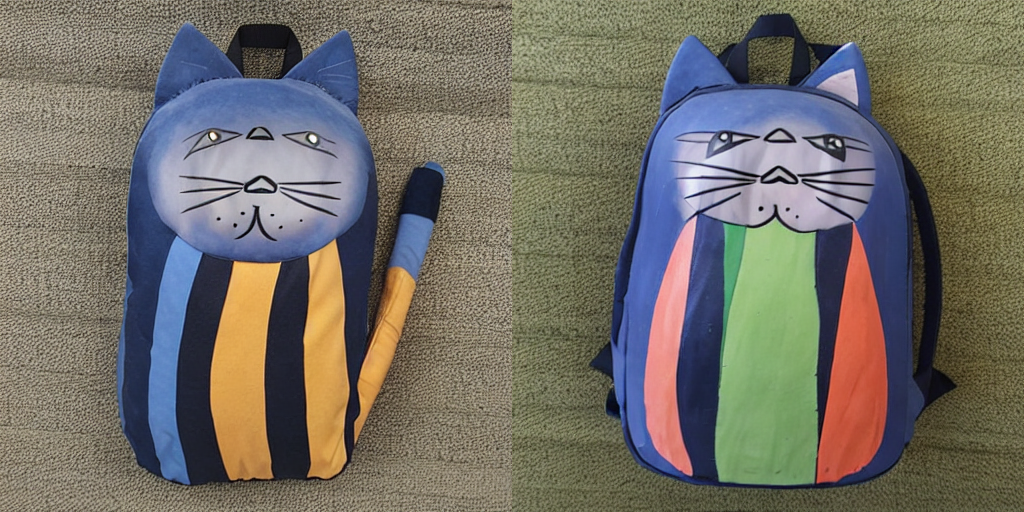

In [24]:
prompt = "A <cat-toy> backpack"

num_samples = 2
num_rows = 1

generator = torch.Generator().manual_seed(19950815)

all_images = []
for _ in range(num_rows):
    images = pipe(
        prompt=prompt,
        num_images_per_prompt=num_samples,
        generator=generator,
        num_inference_steps=25,
        guidance_scale=9
    ).images
    all_images.extend(images)

image_grid(all_images, num_rows, num_samples)